# Is a solar system target visible from a given site?

Uses astropy, astroplan, and sbpy to get information from Horizons about where a target is on the sky, how bright it is, and then whether it is visible at a given observatory at that time (more information about airmass, etc.). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from astroplan import Observer
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroplan.plots import plot_airmass, plot_altitude
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
from astroplan import is_observable

from sbpy.data import Ephem

This can be useful to know which site names are available. 

In [2]:
from astropy.coordinates import EarthLocation

site_names = EarthLocation.get_site_names()

some_sites = {'Siding Spring': 'Siding Spring Observatory', 
              'SALT': 'SALT',
              'Tenerife': 'Observatorio del Teide, Tenerife',              
              'Cerro Pachon': 'Cerro Pachon', 
              'Apache Point': 'Apache Point Observatory', 
              'Kitt Peak': 'Kitt Peak',
              'Palomar': 'Palomar',
              'CFHT': 'Canada-France-Hawaii Telescope',                
             }
lons = []
lats = []
for s in some_sites.values():
    loc = EarthLocation.of_site(s)
    lons.append(loc.lon.deg)
    lats.append(loc.lat.deg)
    
pd.DataFrame([lons, lats], columns=some_sites.keys(), index=['longitude', 'latitude']).T

,longitude,latitude
Siding Spring,149.061194,-31.273361
SALT,20.810808,-32.375823
Tenerife,-16.509722,28.300000
Cerro Pachon,-70.736683,-30.240742
Apache Point,-105.820000,32.780000
Kitt Peak,-111.600000,31.963333
Palomar,-116.863000,33.356000
CFHT,-155.471667,19.826667


Set up site information and time range and target name - query for ephemerides from JPL Horizons.
Add a magnitude cutoff to limit dates/times of interest.

In [3]:
# Set up observer, target, and time
site_name = "Cerro Pachon"
location = EarthLocation.of_site(site_name)
observer = Observer.at_site(site_name)

target = 'C/2023 P1'

epochs = {'start': Time('2022-01-01'),
          'stop': Time('2023-08-20'),
          'step': 15 * u.day}

eph = Ephem.from_horizons(target, location=location, epochs=epochs)
# eph.field_names
magcol = 'Tmag'  # 'V' for asteroids

# Add a brightness cutoff 
magcutoff = 24.5 * u.mag
bright = np.where(eph[magcol] < magcutoff)

ss_vis = eph['epoch', 'rh', 'delta', 'ra', 'dec', 'RA*cos(Dec)_rate', 'DEC_rate', magcol][bright]

ss_vis

<QTable length=28>
  epoch         r             delta           RA      DEC    RA*cos(Dec)_rate  DEC_rate    Tmag 
                AU              AU           deg      deg       arcsec / h    arcsec / h   mag  
   Time      float64         float64       float64  float64      float64       float64   float64
--------- -------------- ---------------- --------- -------- ---------------- ---------- -------
2459760.5 6.964944644842  7.8721687015571  95.10762 -1.67585         17.36724   1.061403   24.41
2459775.5 6.786760821454 7.66103775039922  96.84912 -1.66238         17.56176    -0.8528  24.238
2459790.5  6.60722537581 7.39928974380114  98.56682 -1.84094         16.96556   -2.78264  24.046
2459805.5 6.426266906114 7.09050196153402 100.17454  -2.2114         15.44787   -4.67099  23.833
2459820.5 6.243807721562 6.74062760478011 101.57923 -2.76801         12.93308   -6.49372  23.598
2459835.5 6.059762966491 6.35756541754253 102.67148 -3.49957         9.252834    -8.1425  23.341
2459850.5 5

For a first pass at whether or not a target would be visible at this site .. these limits are pretty loose and the resulting "observable" value just tells you whether or not the timestep has *any* observability option. 

In [4]:
airmass_cutoff = 4.5

constraints = [AltitudeConstraint(15*u.deg, 85*u.deg),
               AirmassConstraint(airmass_cutoff), AtNightConstraint.twilight_astronomical()]

observable = []
year = []
for days, ra, dec in zip(ss_vis['epoch'], ss_vis['ra'], ss_vis['dec']):
    fields = [SkyCoord(ra, dec, frame="icrs")]
    time_range = [days, days + epochs['step']]

    # Are targets *ever* observable in the time range?
    observable.append(is_observable(constraints, observer, fields, time_range=time_range))
    year.append(days.isot.split('T')[0])
    
ss_vis['observable'] = observable
ss_vis['year'] = year

ss_vis['epoch', 'year', 'RA', 'DEC', 'Tmag', 'observable']

<QTable length=28>
  epoch      year        RA      DEC      Tmag  observable
                        deg      deg      mag             
   Time     str10     float64  float64  float64  bool[1]  
--------- ---------- --------- -------- ------- ----------
2459760.5 2022-06-30  95.10762 -1.67585   24.41      False
2459775.5 2022-07-15  96.84912 -1.66238  24.238       True
2459790.5 2022-07-30  98.56682 -1.84094  24.046       True
2459805.5 2022-08-14 100.17454  -2.2114  23.833       True
2459820.5 2022-08-29 101.57923 -2.76801  23.598       True
2459835.5 2022-09-13 102.67148 -3.49957  23.341       True
2459850.5 2022-09-28 103.33029 -4.38507  23.063       True
2459865.5 2022-10-13 103.41474 -5.38827  22.764       True
2459880.5 2022-10-28 102.77872 -6.45151  22.449       True
2459895.5 2022-11-12 101.28193 -7.48318  22.123       True
2459910.5 2022-11-27  98.83542 -8.35529  21.793       True
2459925.5 2022-12-12  95.45972 -8.90244  21.472       True
2459940.5 2022-12-27  91.34994 -8.959

For each of those dates, look more carefully at the target visibility. This can be a lot of plots .. 

WARNING

sunset: 2023-01-25T23:41:09.583
sunrise: 2023-01-26T10:09:47.611
middle: 2023-01-26T04:55:28.597
target rise time: 2023-01-25T19:38:07.485
target set time: 2023-01-26T08:10:01.343


: TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days [astropy.time.core]


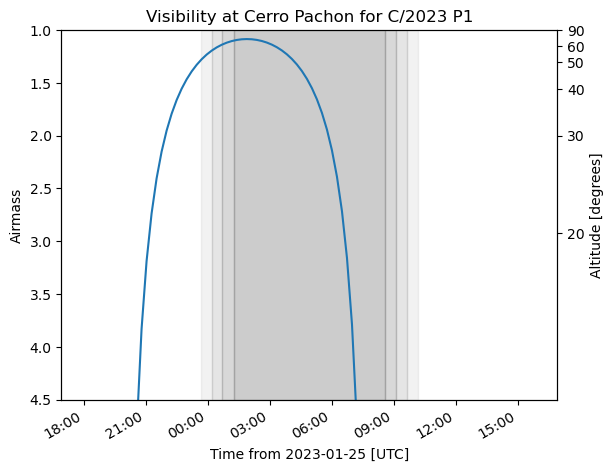

In [5]:
idx = np.where((ss_vis['epoch'] >= Time(2460030.2, format='jd')) & 
               (ss_vis['epoch'] < Time(2460060.5, format='jd'))) 
idx = np.where(ss_vis['year'] == "2023-01-26")

subset = ss_vis[idx]

for days, ra, dec in zip(subset['epoch'], subset['ra'], subset['dec']):
    sunset = observer.sun_set_time(days)
    sunrise = observer.sun_rise_time(days, which='next')

    print('sunset:', sunset.isot)
    print('sunrise:', sunrise.isot)
    observe_time = (sunrise - sunset)/2.0 + sunset
    print('middle:', observe_time.isot)

    field = SkyCoord(ra, dec, frame="icrs")

    rise_time = observer.target_rise_time(observe_time, field)
    print('target rise time:', rise_time.isot)
    set_time = observer.target_set_time(observe_time, field)
    print('target set time:', set_time.isot)

    plot_airmass(field, observer, observe_time, brightness_shading=True,
                altitude_yaxis=True, max_airmass=airmass_cutoff)
    plt.title(f"Visibility at {observer.name} for {target}")
    plt.show()

Or look for when this target might be visible across a range of possible sites, to identify potentially more promising locations.

In [6]:
target = 'C/2023 P1'

epochs = {'start': Time('2022-01-01'),
          'stop': Time('2023-08-20'),
          'step': 15 * u.day}

comparison_vis = []
for site_name in some_sites.values():
    # Set up observer, target, and time
    location = EarthLocation.of_site(site_name)
    observer = Observer.at_site(site_name)

    eph = Ephem.from_horizons(target, location=location, epochs=epochs)
    # eph.field_names
    magcol = 'Tmag'  # 'V' for asteroids

    ss_vis = eph['epoch', 'rh', 'delta', 'ra', 'dec', 'RA*cos(Dec)_rate', 'DEC_rate', magcol]

    airmass_cutoff = 4.5

    constraints = [AltitudeConstraint(15*u.deg, 85*u.deg),
                   AirmassConstraint(airmass_cutoff), AtNightConstraint.twilight_astronomical()]

    observable = []
    year = []
    comparison_mag = []
    for days, ra, dec in zip(ss_vis['epoch'], ss_vis['ra'], ss_vis['dec']):
        fields = [SkyCoord(ra, dec, frame="icrs")]
        time_range = [days, days + 1*u.day]

        # Are targets *ever* observable in the time range?
        observable.append(is_observable(constraints, observer, fields, time_range=time_range)[0])
        year.append(days.isot.split('T')[0])

    comparison_vis.append(observable)
    
comparison = pd.DataFrame(comparison_vis, columns=year, index=some_sites.keys()).T
comparison['mag'] = ss_vis[magcol]/u.mag
comparison

,Siding Spring,SALT,Tenerife,Cerro Pachon,Apache Point,Kitt Peak,Palomar,CFHT,mag
2022-01-01,True,True,True,True,True,True,True,True,25.615
2022-01-16,True,True,True,True,True,True,True,True,25.503
2022-01-31,True,True,True,True,True,True,True,True,25.405
2022-02-15,True,True,True,True,True,True,True,True,25.319
2022-03-02,True,True,True,True,True,True,True,True,25.241
2022-03-17,True,True,True,True,True,True,True,True,25.166
2022-04-01,True,True,True,True,True,True,True,True,25.090
2022-04-16,True,True,True,True,True,True,True,True,25.008
2022-05-01,True,True,False,True,False,False,False,True,24.917
2022-05-16,True,True,False,True,False,False,False,False,24.814


In [8]:
comparison[24:]

,Siding Spring,SALT,Tenerife,Cerro Pachon,Apache Point,Kitt Peak,Palomar,CFHT,mag
2022-12-27,True,True,True,True,True,True,True,True,21.170
2023-01-11,True,True,True,True,True,True,True,True,20.895
2023-01-26,True,True,True,True,True,True,True,True,20.648
2023-02-10,True,True,True,True,True,True,True,True,20.423
2023-02-25,True,True,True,True,True,True,True,True,20.206
2023-03-12,True,True,True,True,True,True,True,True,19.981
2023-03-27,True,True,True,True,True,True,True,True,19.731
2023-04-11,True,True,True,True,True,True,True,True,19.444
2023-04-26,True,True,False,True,False,False,False,False,19.105
2023-05-11,False,False,False,False,False,False,False,False,18.702
